# Tutorial2: 图像分类1

本节旨在展示使用CNN进行图像分类的简单案例，使用MNIST数据集和一个规模较小的简单CNN网络。

分以下几步来实现：
1. 环境安装与应用创建
2. 分步运行本文件

    2.1 数据加载和预处理

    2.2 定义 CNN 模型

    2.3 训练与评估

## 1. 环境安装与应用创建

首先在联网的命令行中创建conda环境:
```bash
conda create -n tutorial2 python=3.9
conda activate tutorial2
pip install notebook jupyterlab numpy==1.26.4 matplotlib==3.8.4
pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116
```

（ pytorch 版本需与 cuda 版本对应，请查看版本对应网站：https://pytorch.org/get-started/previous-versions ）
（ 通过 nvidia-smi 命令可查看 cuda 版本）

然后创建JupyterLab应用, `Conda环境名`请填写`tutorial2`, 硬件资源为1个GPU。创建应用后, 进入应用并打开本文件。

CUDA Version: 12.1; Torch Version: 2.3.1

## 2. 分步运行本文件

### 2.1 数据预处理

MNIST 是一个手写数字数据集，包含了数字0到9的灰度图像。

In [ ]:
%tar -xzf data.tar.gz

In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 定义数据转换方式: 标准化
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为 PyTorch 张量
    transforms.Normalize((0.5,), (0.5,))  # 标准化（均值0.5，标准差0.5）
])

# 加载训练集和测试集
train_dataset = datasets.MNIST('./data', train=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)


## 2.2 定义 CNN 模型

In [2]:

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # 卷积层：输入1通道，输出32通道，卷积核3x3，填充1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2) # 池化层：用于减小输出矩阵大小
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.mp(self.conv1(x)))
        x = self.relu(self.mp(self.conv2(x)))
        x = x.view(x.size(0), -1)  # 展平
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 2.3 训练与评估

完成模型训练和评估在 V100 显卡上需要约 6 min

In [3]:
from torch.utils.data import DataLoader
import torch
import time
from datetime import timedelta

# 参数设置
learning_rate, epochs, batch_size = 0.001, 20, 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# 实例化模型
model = CNN().to(device)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

# 评估函数
def accuracy(model, data_loader, device):
    total = 0
    correct = 0
    model.eval()
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    return 100 * correct / total
    
# 数据准备
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 训练模型
train_ls = []
train_acc, test_acc = [], []
for epoch in range(epochs):
    start_time = time.time()
    model.train() 
    total_loss = 0
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        
        # 前向传播
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss 记录
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    train_ls.append(average_loss)
        
    # 模型评估
    with torch.no_grad():
        train_acc.append(accuracy(model, train_loader, device))
        test_acc.append(accuracy(model, test_loader, device))
    
    # 计时
    end_time = time.time()
    print(f"{epoch}/{epochs}: accuracy: {test_acc[-1]} | time consuming: {timedelta(seconds=end_time - start_time)}")

Using device: cuda
0/20: accuracy: 98.07 | time consuming: 0:00:20.484834
1/20: accuracy: 98.48 | time consuming: 0:00:17.870257
2/20: accuracy: 98.69 | time consuming: 0:00:17.827839
3/20: accuracy: 98.94 | time consuming: 0:00:17.885543
4/20: accuracy: 98.99 | time consuming: 0:00:18.206810
5/20: accuracy: 98.7 | time consuming: 0:00:18.379300
6/20: accuracy: 99.03 | time consuming: 0:00:18.142421
7/20: accuracy: 99.04 | time consuming: 0:00:17.860128
8/20: accuracy: 98.9 | time consuming: 0:00:17.888026
9/20: accuracy: 98.94 | time consuming: 0:00:18.103130
10/20: accuracy: 99.17 | time consuming: 0:00:17.779486
11/20: accuracy: 98.67 | time consuming: 0:00:18.168736
12/20: accuracy: 99.0 | time consuming: 0:00:17.885525
13/20: accuracy: 98.97 | time consuming: 0:00:18.084002
14/20: accuracy: 99.06 | time consuming: 0:00:17.851521
15/20: accuracy: 99.11 | time consuming: 0:00:17.829083
16/20: accuracy: 99.16 | time consuming: 0:00:17.777250
17/20: accuracy: 98.88 | time consuming: 0

训练过程中 Loss 一直在下降，本次训练中最高能达到 99% 的准确率，实际上通过改进模型和训练过程并进行数据增强，CNN训练MNIST数据集的准确率可以进一步提升。

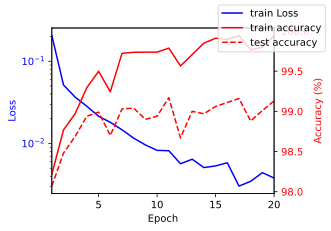

In [4]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = (4, 3)

fig, ax1 = plt.subplots()

# loss
ax1.plot(list(range(1, epochs + 1)), train_ls, 'b-', label='train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_yscale('log')
ax1.set_xlim([1, epochs])

# Accuracy
ax2 = ax1.twinx()  
ax2.plot(list(range(1, epochs + 1)), train_acc, 'r-', label='train accuracy')
ax2.plot(list(range(1, epochs + 1)), test_acc, 'r--', label='test accuracy')
ax2.set_ylabel('Accuracy (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend()

---

> 作者: 黎颖; 龙汀汀
>
> 联系方式: yingliclaire@pku.edu.cn;   l.tingting@pku.edu.cn